### LSTM으로 주가 예측하기

In [1]:
# TensorFlow 패키지 소개
# https://datascienceschool.net/view-notebook/5cbab09d777841f591a67928d7043f51/

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.contrib import rnn

import os
import datetime
import matplotlib.pyplot as plt
import numpy as np 
import seaborn
import pickle
import quandl

np.set_printoptions(precision=2)

C:\Users\JerryKim\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\JerryKim\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\JerryKim\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\JerryKim\AppData

### 함수 가지고 오기

In [3]:
# 평가 함수 (Evaluation function)
def evaluate_ts(features, y_true, y_pred):
    print("Evaluation of the predictions :")
    # 평균 제곱 오차 (Mean Squared Error)
    print("MSE(평균 제곱 오차) : ", np.mean(np.square(y_true - y_pred)))
    # 평균 절대 오차 (Mean Absolute Error)
    print("MAE(평균 절대 오차) : ", np.mean(np.abs(y_true - y_pred)))
    
    #
    print("Benchmark : if prediction == last feature")
    print("MSE : ", np.mean(np.square(features[:,-1]- y_true)))
    print("mae : ", np.mean(np.abs(features[:,-1]- y_true)))
    
    #  성능을 시각적으로 확인 할 수 있게 
    plt.plot(matrix_to_array(y_true), 'b')
    plt.plot(matrix_to_array(y_pred), 'r--')
    plt.xlabel("Days")
    plt.ylabel("Predicted and true values")
    plt.title("Predicted (Red) VS Real (Blue)")
    plt.show()
    
    #
    error = np.abs(matrix_to_array(y_pred)- matrix_to_array(y_true))
    plt.plot(error,'r')
    fit   = np.polyfit(range(len(error)), error, deg = 1)
    plt.plot(fit[0] * range(len(error)) + fit[1], '--')
    plt.xlabel("Days")
    plt.ylabel("Prediction error L1 norm")
    plt.title("Prediction error (absolute) and trendline")
    plt.show()
    
# 코사인 신호를 생성하는 함수
# 점의 개수, 신호 주기, 균일한 잡음 생성기의 절대 강도가 매개변수로 주어졌을 때

# seq_len : 점의 개수 // frequency : 신호주기 // noise  : 잡음
def fetch_cosine_values(seq_len, frequency = 0.01, noise = 0.1) :
    np.random.seed(101)
    # random_ seed : fetch_cosine_values가 가진 범위 안에서 난수 수열을 랜덤으로 생성..101 
    x = np.arange(0.0, seq_len, 1.0)
    
    return np.cos( 2 * np.pi * frequency * x ) + np.random.uniform(low=-noise, high=noise, size=seq_len)

# 데이터 셋 함수
def format_dataset(values, temporal_features) : 
    # 
    feat_splits = [] 
    for i in range(len(values) - temporal_features):
        feat_splits.append(values[i:i+temporal_features])
        
    # 모든 관측값 => 레이블과 함께 세로로 연결
    # https://docs.scipy.org/doc/numpy/reference/generated/numpy.vstack.html
    #vstack : 배열을 수직으로 
    feats  = np.vstack(feat_splits)
    labels = np.array(values[temporal_features :])
    
    # 정해진 개수의 열을 갖는 관측값과 레이블 벡터
    return feats, labels

def matrix_to_array(m) :
    return np.asarray(m).reshape(-1)

def fetch_stock_price(symbol, from_date, to_date, cache_path = './tmp/prices/'):
    
    assert(from_date <= to_date)
    filename = "{}_{}_{}.pk".format(symbol, str(from_date), str(to_date))
    price_filepath = os.path.join(cache_path, filename)
    
    try : 
        price = load_pickle(price_filepath)
        print("--")
        print("loaded from", price_filepath)
    except IOError :
        historic = quandl.get("WIKI/" + symbol,
                              start_date = date_obj_to_str(from_date),
                              end_date   = date_obj_to_str(to_date))
        
        prices = historic["Adj. Close"].tolist()
        save_pickle(prices , price_filepath)
        print("saved into", price_filepath)
    return prices


def date_obj_to_str(date_obj):
    # yyyy-mm-dd
    return date_obj.strftime('%y-%m-%d')

def save_pickle(something, path): 
    if not os.path.exists(os.path.dirname(path)):
        os.makedirs(os.path.dirname(path))
        with open(path, 'wb') as fh:
            # 
            pickle.dump(something, fh , pickle.DEFAULT_PROTOCOL)
            
def load_pickle(path):
    with open(path, 'rb') as fh :
        return pickle.load(fh)
    
# api 개인 (quandl = "kF3tPMFDQoSdoL6MUs8s" )
quandl.ApiConfig.api_key =  "kF3tPMFDQoSdoL6MUs8s"

In [4]:
# tf.reset_default_graph()
# tf.set_random_seed(101)
# np.random.seed(101)

# time_dimension = 20
# train_size     = 250
# test_size      = 250

# learning_rate = 0.01
# optimizer     = tf.train.AdagradOptimizer
# n_epochs      = 2000
# n_embeddings  = 64

# # 관측 행렬 
# cos_values = fetch_cosine_values(train_size + test_size + time_dimension)
# minibatch_cos_X, minibatch_cos_y = format_dataset(cos_values, time_dimension)

# # 분석 속도를 높이기위해서 -> np.float32
# train_X = minibatch_cos_X[:train_size, :].astype(np.float32)
# train_y = minibatch_cos_y[:train_size].reshape((-1, 1)).astype(np.float32)
# test_X  = minibatch_cos_X[train_size:, :].astype(np.float32)
# test_y  = minibatch_cos_y[train_size:].reshape((-1, 1)).astype(np.float32)

# train_X_ts = train_X[:,:,np.newaxis]
# test_X_ts  = test_X[:,:,np.newaxis]

# # 플레이스홀더 정의 
# X_tf = tf.placeholder("float", shape =(None, time_dimension, 1), name= "X")
# y_tf = tf.placeholder("float", shape =(None, 1), name= "y")

# def RNN( x, weights, biases ):
#     x_ = tf.unstack(x, time_dimension, 1)
#     lstm_cell = rnn.BasicLSTMCell(n_embeddings)
#     outputs, _  = rnn.static_rnn(lstm_cell, x_ , dtype= tf.float32)
#     return tf.add(biases, tf.matmul(outputs[-1], weights))

# weights = tf.Variable(tf.truncated_normal([n_embeddings, 1], mean = 0.0, stddev = 1.0), name="weights")
# biases  = tf.Variable(tf.zeros([1]), name="bias")

# y_pred   = RNN(X_tf, weights, biases)
# cost     = tf.reduce_mean(tf.square(y_tf- y_pred))
# train_op = optimizer(learning_rate).minimize(cost)

# # 메인 루프
# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
    
# #  각 세대마다 전체 훈련데이터셋이 텐서플로 그래프에 공급 

#     for i in range(n_epochs):
#         train_cost,_ = sess.run([cost, train_op], feed_dict={X_tf:train_X_ts, y_tf:train_y})
#         if i%100 ==0:
#             print("Training iteration", i, "MSE", train_cost)
    
#     # 훈련 후 테스트 데이터셋에 성능을 확인
#     test_cost, y_pr = sess.run([cost, y_pred], feed_dict={X_tf:test_X_ts, y_tf: test_y})
#     print("Test dataset: ", test_cost)
    
#     evaluate_ts(test_X, test_y, y_pr)
    
#     plt.plot(range(len(cos_values)), cos_values, 'b')
#     plt.plot(range(len(cos_values) - test_size, len(cos_values)), y_pr, 'r--')
#     plt.xlabel("Days")
#     plt.ylabel("Predicted and true values")
#     plt.title("Predicted(Red) VS Real(Blue)")
#     plt.show()

In [5]:
# LSTM   >> 신호에 포함된 시간적 중복을 활용 
# 두개의 출력
#1. 모델의 실 출력
#2. 단계의 내부 상태 = '메모리'

# 삼차원 입력신호
# 샘플수, 시간단계, 특징수 

In [6]:
# 1. 첫번째 축은 샘플을 포함한다.
# 2. 두번째 축은 시계열 데이터를 포함한다. 
# 3. 세번째 축은 입력 특징을 포함한다.

# 우리는 1차원 신호만 처리 _ 입력 텐서의 크기(None, time_dimenstion, 1)

In [7]:
# tf.reset_default_graph()
# tf.set_random_seed(101)

# # 원도우 크기를 신호 양으로 설정_관측 행렬을 생성하는 것과 비슷
# time_dimension = 20
# train_size     = 250
# test_size      = 250

# #텐서플로를 설정_ 기본값
# learning_rate = 0.01
# optimizer     = tf.train.AdamOptimizer
# n_epochs      = 10000
# n_embeddings  = 64

# # 잡음이 섞인 코사인을 가져와 3차원 텐서 형상(None, time_dimenstion, 1)변환 
# cos_values = fetch_cosine_values(train_size + test_size + time_dimension)
# minibatch_cos_X, minibatch_cos_y = format_dataset(cos_values, time_dimension)

# # 분석 속도를 높이기위해서 -> np.float32
# train_X = minibatch_cos_X[:train_size, :].astype(np.float32)
# train_y = minibatch_cos_y[:train_size].reshape((-1, 1)).astype(np.float32)
# test_X  = minibatch_cos_X[train_size:, :].astype(np.float32)
# test_y  = minibatch_cos_y[train_size:].reshape((-1, 1)).astype(np.float32)

# train_X_ts = train_X[:,:,np.newaxis]
# test_X_ts  = test_X[:,:,np.newaxis]

# # 플레이스홀더 정의 
# X_tf = tf.placeholder("float", shape =(None, time_dimension, 1), name= "X")
# y_tf = tf.placeholder("float", shape =(None, 1), name= "y")

# #------------------------------------------------------------------------------
# #  모델 정의 
# def RNN( x, weights, biases ):
#     x_ = tf.unstack(x, time_dimension, 1)
#     lstm_cell = rnn.BasicLSTMCell(n_embeddings)
#     outputs, _  = rnn.static_rnn(lstm_cell, x_ , dtype= tf.float32)
#     return tf.add(biases, tf.matmul(outputs[-1], weights))

# # 훈련가능한 변수 cost함수 훈련연산자 설정
# weights = tf.Variable(tf.truncated_normal([n_embeddings, 1], mean = 0.0, stddev = 1.0), name="weights")
# biases  = tf.Variable(tf.zeros([1]), name="bias")

# y_pred   = RNN(X_tf, weights, biases)
# cost     = tf.reduce_mean(tf.square(y_tf- y_pred))
# train_op = optimizer(learning_rate).minimize(cost)

# # 메인 루프
# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
    
# #  각 세대마다 전체 훈련데이터셋이 텐서플로 그래프에 공급 

#     for i in range(n_epochs):
#         train_cost,_ = sess.run([cost, train_op], feed_dict={X_tf:train_X_ts, y_tf:train_y})
#         if i%100 ==0:
#             print("Training iteration", i, "MSE", train_cost)
    
#     # 훈련 후 테스트 데이터셋에 성능을 확인
#     test_cost, y_pr = sess.run([cost, y_pred], feed_dict={X_tf:test_X_ts, y_tf: test_y})
#     print("Test dataset: ", test_cost)
    
#     evaluate_ts(test_X, test_y, y_pr)
    
#     plt.plot(range(len(cos_values)), cos_values, 'b')
#     plt.plot(range(len(cos_values) - test_size, len(cos_values)), y_pr, 'r--')
#     plt.xlabel("Days")
#     plt.ylabel("Predicted and true values")
#     plt.title("Predicted(Red) VS Real(Blue)")
#     plt.show()r

saved into ./tmp/prices/MSFT_2015-01-01_2016-12-31.pk
Training iteration 0 MSE 1137.4746
Training iteration 100 MSE 2.640239
Training iteration 200 MSE 1.5634234
Training iteration 300 MSE 1.3562232
Training iteration 400 MSE 1.2688527
Training iteration 500 MSE 1.1914355
Training iteration 600 MSE 1.1245066
Training iteration 700 MSE 1.0591431
Training iteration 800 MSE 1.0000547
Training iteration 900 MSE 0.9515034
Training iteration 1000 MSE 0.9131744
Training iteration 1100 MSE 0.8830249
Training iteration 1200 MSE 0.8590814
Training iteration 1300 MSE 0.839594
Training iteration 1400 MSE 0.8233347
Training iteration 1500 MSE 0.8094268
Training iteration 1600 MSE 0.7971695
Training iteration 1700 MSE 0.7861332
Training iteration 1800 MSE 0.77598345
Training iteration 1900 MSE 0.7664813
Training iteration 2000 MSE 0.757399
Training iteration 2100 MSE 0.7486714
Training iteration 2200 MSE 0.74036694
Training iteration 2300 MSE 0.73215884
Training iteration 2400 MSE 0.7242644
Training

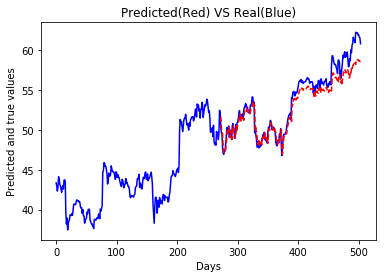

In [9]:
tf.reset_default_graph()
tf.set_random_seed(101)
#np.random.seed(101)

# 원도우 크기를 신호 양으로 설정_관측 행렬을 생성하는 것과 비슷
symbol         = "MSFT"
time_dimension = 20
train_size     = 252
test_size      = 252 - time_dimension

#텐서플로를 설정_ 기본값
learning_rate = 0.05
# optimizer     = tf.train.AdamOptimizer
optimizer     = tf.train.AdagradOptimizer
n_epochs      = 5000
n_embeddings  = 256

# 잡음이 섞인 코사인을 가져와 3차원 텐서 형상(None, time_dimenstion, 1)변환 
stock_values = fetch_stock_price(symbol, datetime.date(2015,1,1), datetime.date(2016,12,31))
minibatch_stock_X, minibatch_stock_y = format_dataset(stock_values, time_dimension)

# 분석 속도를 높이기위해서 -> np.float32
train_X = minibatch_stock_X[:train_size, :].astype(np.float32)
train_y = minibatch_stock_y[:train_size].reshape((-1, 1)).astype(np.float32)
test_X  = minibatch_stock_X[train_size:, :].astype(np.float32)
test_y  = minibatch_stock_y[train_size:].reshape((-1, 1)).astype(np.float32)

train_X_ts = train_X[ :, :, np.newaxis ]
test_X_ts  = test_X[ :, :, np.newaxis ]

# 플레이스홀더 정의 
X_tf = tf.placeholder("float", shape =(None, time_dimension, 1), name= "X")
y_tf = tf.placeholder("float", shape =(None, 1), name= "y")

#------------------------------------------------------------------------------
#  모델 정의 
def RNN( x, weights, biases ):
    x_ = tf.unstack(x, time_dimension, 1)
    lstm_cell   = rnn.BasicLSTMCell(n_embeddings)
    outputs, _  = rnn.static_rnn(lstm_cell, x_ , dtype= tf.float32)
    return tf.add(biases, tf.matmul(outputs[-1], weights))
#------------------------------------------------------------------------------

# 훈련가능한 변수 cost함수 훈련연산자 설정
weights = tf.Variable(tf.truncated_normal([n_embeddings, 1], mean = 0.0, stddev = 10.0), name="weights")
biases  = tf.Variable(tf.zeros([1]), name="bias")

y_pred   = RNN(X_tf, weights, biases)
cost     = tf.reduce_mean(tf.square(y_tf- y_pred))
train_op = optimizer(learning_rate).minimize(cost)

# 메인 루프
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #merged = tf.summary.merge_all()
    
#  각 세대마다 전체 훈련데이터셋이 텐서플로 그래프에 공급 
    for i in range(n_epochs):
        #train_cost ,_ = sess.run([cost, train_op], feed_dict={X_tf:train_X, y_tf:train_y})
        train_cost, _ = sess.run([cost, train_op], feed_dict={X_tf:train_X_ts, y_tf:train_y})
#         add_summary(summary, i)
        if i%100 == 0:
            print("Training iteration", i, "MSE", train_cost)
    
    # 훈련 후 테스트 데이터셋에 성능을 확인
    test_cost, y_pr = sess.run([cost, y_pred], feed_dict={X_tf:test_X_ts, y_tf:test_y})
    print("Test dataset: ", test_cost)
    
    #evaluate_ts(test_X, test_y, y_pr)
    
    plt.plot(range(len(stock_values)), stock_values, 'b')
    plt.plot(range(len(stock_values) - test_size, len(stock_values)), y_pr, 'r--')
    plt.xlabel("Days")
    plt.ylabel("Predicted and true values")
    plt.title("Predicted(Red) VS Real(Blue)")
    plt.show()